In [1]:
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import copy, time
import random
import pickle

import mlrfit as mf

/Users/parshakova.tanya/opt/anaconda3/envs/routing/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
np.random.seed(1001)
random.seed(1001)

In [3]:
def plot_groups_cov(hat_A, filename=""):
    n = hat_A.B.shape[0]
    idx = hat_A.hpart['cols']['lk'][1] 
    group1, group2 = hat_A.hpart['rows']['pi'][idx[0]:idx[1]], hat_A.hpart['rows']['pi'][idx[1]:idx[2]]
    res = np.repeat(np.concatenate([(group1<n//2), (group2<n//2)]).reshape(1, -1), 100, axis=0)
    fig, ax = plt.subplots(1, 1, figsize=(5, 10), dpi=150)
    missclassified = (group1>=n//2).sum()+(group2<n//2).sum()
    print(f"number_misclassified={min(missclassified, n - missclassified)}")
    ax.matshow(res)

    ax.set_xticks([0, n//2, n])
    ax.set_yticks([])
    ax.tick_params(which='both', bottom=False, top=False, left=False, right=False)
    if filename:
        plt.savefig(filename, bbox_inches='tight')
    plt.show()

#  Matrix definition

In [4]:
rank = 20
mtype = 'hier_cov'

nsamples = 200
n = m = 2000

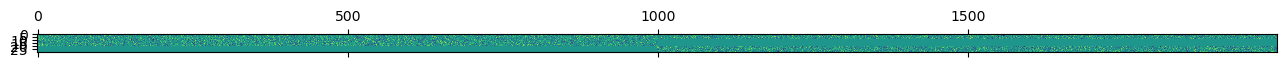

In [5]:
true_F1 = np.random.randn(n, rank//2)
zeros = np.zeros((n//2, rank//2))
true_F2 = np.block([[np.random.randn(n//2, rank//2), zeros],\
                    [zeros, np.random.randn(n//2, rank//2)]]) 
true_F = np.concatenate([true_F1, true_F2], axis=1)

plt.matshow(true_F.T)

In [6]:
signal_to_noise = 1
avg_signal_variance = np.sum(np.diag(true_F @ true_F.T)) / n
D_noise = np.random.uniform(0, (2/signal_to_noise)*avg_signal_variance, n)

print(f"signal_var={np.diag(true_F @ true_F.T).mean()}, noise_var={D_noise.mean()}")

true_covariance = true_F @ true_F.T + np.diag(D_noise)

signal_var=20.20539229386476, noise_var=20.02646098046111


In [7]:
def generate_data(true_F, D_noise, nsamples):
    z = np.random.randn(true_F.shape[1], nsamples)
    eps = np.random.multivariate_normal(np.zeros(D_noise.size), np.diag(D_noise), size=nsamples).T
    C = true_F @ z + eps
    return C

C = generate_data(true_F, D_noise, nsamples)

Z = C - C.mean(axis=1, keepdims=True)
A = Z @ Z.T / (Z.shape[1]-1)

In [8]:
np.linalg.norm(A - true_covariance, 'fro') / np.linalg.norm(true_covariance, 'fro') 

0.7185164327745631

In [9]:
C.shape, Z.shape, A.shape

((2000, 200), (2000, 200), (2000, 2000))

In [10]:
U, Vt, sigmas = mf.frob_low_rank(A)
frob_losses = np.zeros(m)
normalization = np.linalg.norm(A, ord='fro')
# assert np.allclose(normalization, ((sigmas**2).sum())**0.5)
sigmas2 = (sigmas**2)[::-1]
frob_losses = np.concatenate([(np.cumsum(sigmas2)**0.5)[::-1][1:] / normalization, np.array([0])])

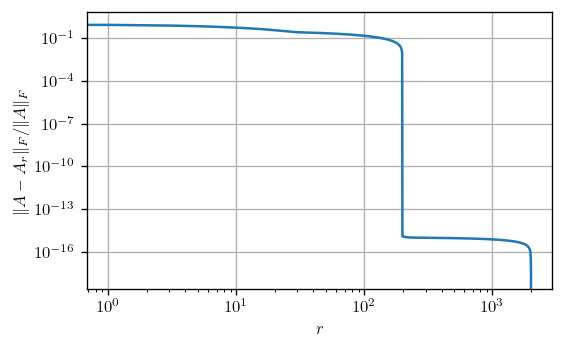

In [11]:
mf.plot_frob_error_rank(frob_losses)

In [12]:
C.shape, A.shape, A.min(), A.max(), A.mean(), A.std()

((2000, 200),
 (2000, 2000),
 -31.925494957032758,
 86.38901608583227,
 0.020083275420626753,
 4.993132206100333)

In [13]:
eps_ff = 1e-2
eps = 1e-3

In [14]:
method = 'bcd'
svds_v0 = True
max_iters_ff = 2
max_iters = 3*10**3
grref_max_iters = 5000
PSD = True
symm = True

filename = "%s_r%d_%d"%(mtype, rank, n)

# Rank allocation + spectral partitioning + greedy refinement

In [15]:
info = {} 

In [16]:
# LR
hpart = mf.random_hpartition(m, n, num_levels=1, symm=symm, perm=False)
B1, C1 = mf.single_level_factor_fit(A, np.array([rank]), hpart, level=0, symm=symm, PSD=PSD)[:2]
info['LR'] = {'loss':[mf.rel_diff(B1 @C1.T, den=A)]}
print(info['LR']['loss'])

[0.38771933462437946]


In [17]:
# LR+D fitting
hpart = mf.random_hpartition(m, n, level_list=[0, int(np.log2(m))+1], symm=symm, perm=False)
assert hpart['rows']['lk'][1].size == min(m,n)+1
ranks = np.array([rank-1, 1])
hat_A = mf.MLRMatrix(hpart=hpart, ranks=ranks)
start_time = time.time()
fa_losses = hat_A.factor_fit(A, ranks, hat_A.hpart, method=method, eps_ff=eps_ff/10000, \
                                  freq=100, svds_v0=svds_v0,\
                                  printing=False, max_iters_ff=max_iters, symm=symm, warm_start=False)
fa_time = time.time()-start_time
info['LR+D'] = {'loss':fa_losses, 'time':fa_time}
print(f"{fa_losses[-1]=} {len(fa_losses)} time={fa_time:.3f}")

/Users/parshakova.tanya/Documents/projects/MLR_Matrices/mlr_fitting/mlrfit/utils.py:410: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  hat_A_except_level[r1:r2, c1:c2] += np.dot(B_level[r1:r2], C_level[c1:c2].T)


fa_losses[-1]=0.3905110281197199 4 time=4.663


In [18]:
num_levels = int(np.ceil(np.log2(min(m,n)))+1)

In [19]:
# uniform rank initialization + top down hierarchy + rank allocation
ranks = mf.uniform_ranks(rank, num_levels) 
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_uni = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=False)
ra_time = time.time()-start_time
info['MLR uniform'] = {'loss':ra_losses, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")

[2 2 2 2 2 2 2 2 1 1 1 1]
* level=0, losses[0]=0.886, losses[-1]=0.886, len(losses)=2, [2]


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


* level=1, losses[0]=0.824, losses[-1]=0.824, len(losses)=2, [2 2]
* level=2, losses[0]=0.774, losses[-1]=0.774, len(losses)=2, [2 2 2]
* level=3, losses[0]=0.744, losses[-1]=0.744, len(losses)=2, [2 2 2 2]
* level=4, losses[0]=0.733, losses[-1]=0.733, len(losses)=2, [2 2 2 2 2]
* level=5, losses[0]=0.729, losses[-1]=0.729, len(losses)=2, [2 2 2 2 2 2]
* level=6, losses[0]=0.726, losses[-1]=0.726, len(losses)=2, [2 2 2 2 2 2 2]
* level=7, losses[0]=0.724, losses[-1]=0.724, len(losses)=2, [2 2 2 2 2 2 2 2]
* level=8, losses[0]=0.723, losses[-1]=0.723, len(losses)=2, [2 2 2 2 2 2 2 2 1]
* level=9, losses[0]=0.721, losses[-1]=0.721, len(losses)=2, [2 2 2 2 2 2 2 2 1 1]
* level=10, losses[0]=0.721, losses[-1]=0.721, len(losses)=2, [2 2 2 2 2 2 2 2 1 1 1]
* level=11, losses[0]=0.721, losses[-1]=0.721, len(losses)=2, [2 2 2 2 2 2 2 2 1 1 1 1]
level=11, loss=0.7206063928160586
td_losses[-1]=0.7206063928160586 time=51.601
itr=0, t=3, losses[0]=0.7235313322890752, losses[-1]=0.721047579577716, 

number_misclassified=10


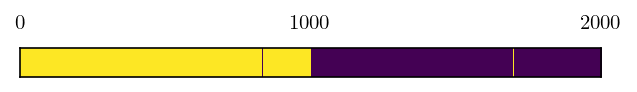

In [20]:
plot_groups_cov(hat_A)

In [21]:
# bottom rank initialization + top down hierarchy + rank allocation
ranks = np.array((num_levels-1)*[0]+[rank]) 
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_bottom = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=False)
ra_time = time.time()-start_time
info['MLR bottom'] = {'loss':ra_losses, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")

[ 0  0  0  0  0  0  0  0  0  0  0 20]
* level=0, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0]
* level=1, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0]
* level=2, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0]
* level=3, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0]
* level=4, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0]
* level=5, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0]
* level=6, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0]
* level=7, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0]
* level=8, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0]
* level=9, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0 0]
* level=10, losses[0]=1.000, losses[-1]=1.000, len(losses)=2, [0 0 0 0 0 0 0 0 0 0 0]
* level=11, losses[0]=0.981, losses[-1]=0.981, len(losses)=2, [ 0  0  0  0  0  0  0  0  0  0  0 20]
level=11, loss=0.9814139209179343
td

number_misclassified=10


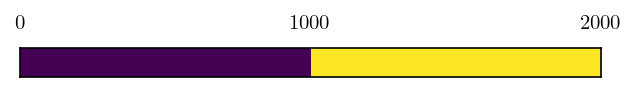

In [22]:
plot_groups_cov(hat_A)

In [23]:
# top rank initialization +  top down hierarchy + rank allocation
ranks = np.array([rank]+(num_levels-1)*[0])
print(ranks)
hat_A = mf.MLRMatrix()
start_time = time.time()
td_losses, _ = hat_A.hpartition_topdown(A, ranks, eps_ff=eps_ff, symm=symm, max_iters_ff=1, \
                                        PSD=PSD, grref_max_iters=grref_max_iters)
td_time = time.time()-start_time
print(f"{td_losses[-1]=} time={td_time:.3f}")
start_time = time.time()
ra_losses, epochs, ranks_history_top = hat_A.rank_alloc(A, ranks, hat_A.hpart, freq=1,\
                        eps=eps, eps_ff=eps_ff, max_iters=max_iters, PSD=PSD, symm=symm,\
                        max_iters_ff=max_iters_ff, warm_start=False)
ra_time = time.time()-start_time
info['MLR top'] = {'loss':ra_losses, 'ra_time':ra_time, 'epochs':epochs}
print(f"td+ra time={ra_time:.3f}")

[20  0  0  0  0  0  0  0  0  0  0  0]
* level=0, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20]
* level=1, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0]
* level=2, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0]
* level=3, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0]
* level=4, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0  0]
* level=5, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0  0  0]
* level=6, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0  0  0  0]
* level=7, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0  0  0  0  0]
* level=8, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0  0  0  0  0  0]
* level=9, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0  0  0  0  0  0  0]
* level=10, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  0  0  0  0  0  0  0  0  0]
* level=11, losses[0]=0.388, losses[-1]=0.388, len(losses)=2, [20  0  

number_misclassified=816


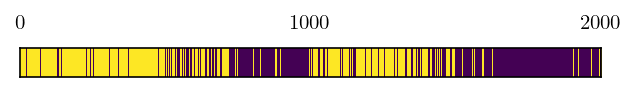

In [24]:
plot_groups_cov(hat_A)

In [25]:
# mf.plot_loss_all_info(info, figsize=(7, 5), dpi=120, logscale=False, hline=True, ylim=[0.14, 0.3], filename='')

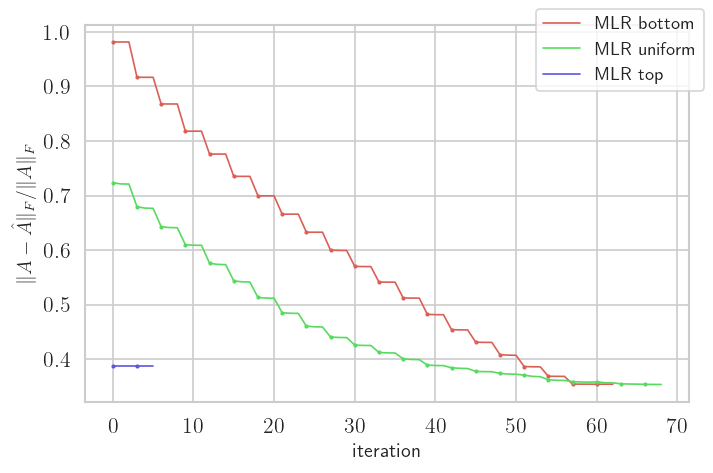

In [27]:
mf.plot_loss_all_info(info, labels=['MLR bottom', 'MLR uniform', 'MLR top'], figsize=(6, 4), dpi=120, \
                        logscale=False, hline=False,) #filename="../plots/loss_%s.pdf"%filename)

In [28]:
for i, algo in enumerate(info.keys()):
    print(f"{algo:14s} {info[algo]['loss'][-1]}")

LR             0.38771933462437946
LR+D           0.3905110281197199
MLR uniform    0.3536912867280212
MLR bottom     0.35414886733031425
MLR top        0.38771933462437963


In [29]:
# with open('../outputs/info_%s.pickle'%filename, 'wb') as handle:
#     pickle.dump(info, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:
rh_top = np.stack(ranks_history_top, axis=0)
rh_bot = np.stack(ranks_history_bottom, axis=0)
rh_uni = np.stack(ranks_history_uni, axis=0)

# with open('../outputs/ranks_%s.pickle'%filename, 'wb') as handle:
#     pickle.dump([rh_bot, rh_uni, rh_top], handle, protocol=pickle.HIGHEST_PROTOCOL)

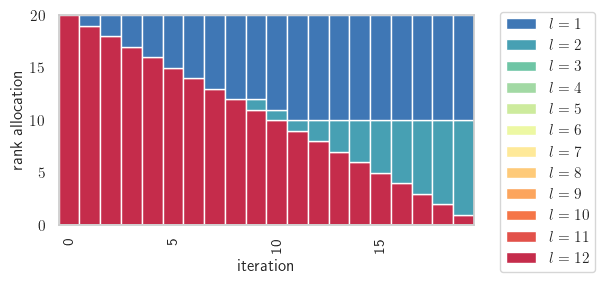

In [31]:
mf.plot_ra_evolution_col([rh_bot],  dpi=100, figsize=(5, 3),) #filename="../plots/ra_%s.pdf"%filename)

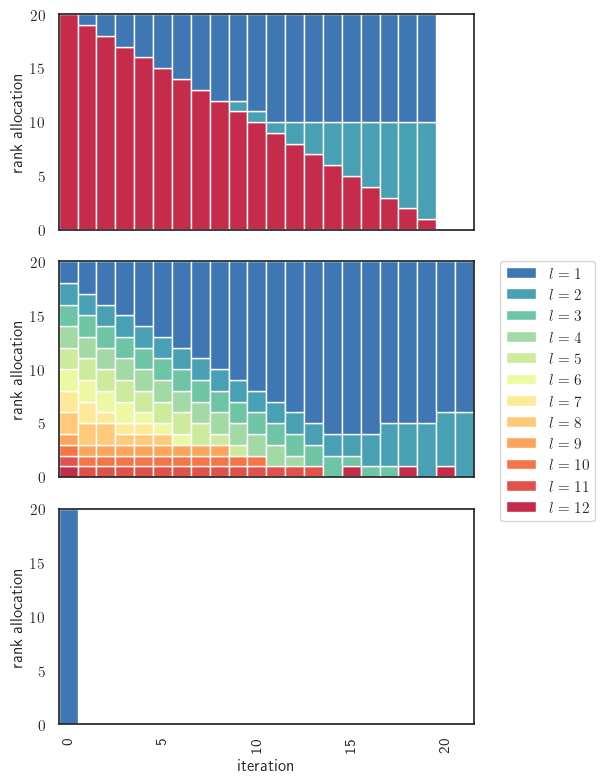

In [32]:
mf.plot_ra_evolution_col([rh_bot, rh_uni, rh_top],  dpi=100, figsize=(5, 8)) #, filename="../plots/ra_%s.pdf"%filename)